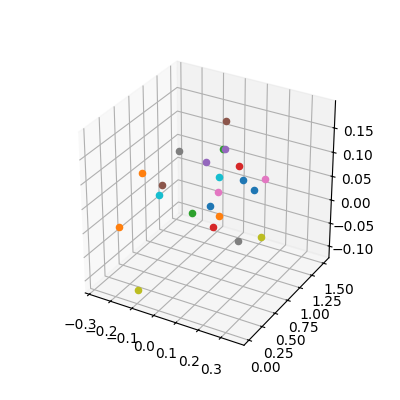

In [5]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

results = np.load('./priorMDM/save/my_humanml_trans_enc_512/DoubleTake_samples_my_humanml_trans_enc_512_000200000_seed10_handshake_20_double_take_blend_10_skipSteps_100/results.npy', allow_pickle=True).item()
motion = results['motion'][0]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1,1,1))

for i in motion:
    ax.scatter(i[0][0], i[1][0], i[2][0])

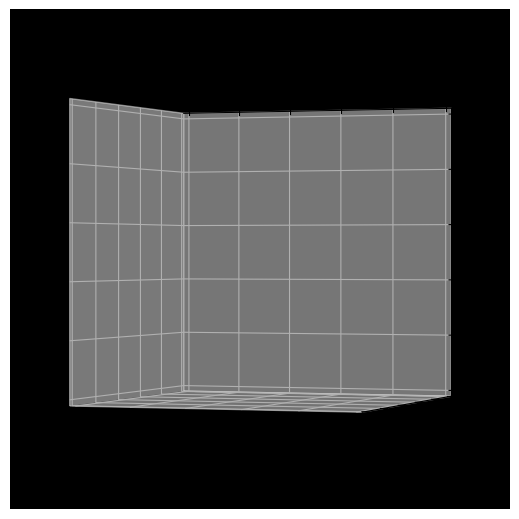

In [1]:
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

results = np.load('./priorMDM/save/my_humanml_trans_enc_512/DoubleTake_samples_my_humanml_trans_enc_512_000200000_seed10_handshake_20_double_take_blend_10_skipSteps_100/results.npy', allow_pickle=True).item()
motion = results['motion'][0]
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')

# https://stackoverflow.com/questions/25575729/how-to-zoom-with-axes3d-in-matplotlib

RADIUS = 1.0  # Control this value.
# ax.set_xlim3d(-RADIUS / 2, RADIUS / 2)
# ax.set_zlim3d(-RADIUS / 2, RADIUS / 2)
# ax.set_ylim3d(-RADIUS / 2, RADIUS / 2)

# https://observablehq.com/@hellonearthis/bwalker-to-open-pose

joints = [
    (1,'#0055FF'),
    (2,'#00FFAA'),
    (4,'#0000FF'),
    (5,'#00FFFF'),
    (7,'#5500FF'),
    (8,'#00AAFF'),
    (9,'#FF5500'),
    (12,'#FF0000'),
    # (15,'#000000'),
    (16,'#55FF00'),
    (17,'#FFAA00'),
    (18,'#00FF00'),
    (19,'#FFFF00'),
    (20,'#00FF55'),
    (21,'#AAFF00')
]

connections = [
    ((9,1),'#009999'),
    ((1,4),'#006699'),
    ((4,7),'#003399'),
    ((9, 2),'#009900'),
    ((2,5),'#009933'),
    ((5,8),'#009966'),
    ((17,19),'#996600'),
    ((19, 21),'#999900'),
    ((16, 18),'#669900'),
    ((18, 20),'#339900'),
    ((16, 9),'#993300'),
    ((17, 9),'#990000'),
    ((9, 12),'#000099'),
]

images = []
for i in range(0, 4):
    ax.set_box_aspect((1,1,1))
    ax.view_init(70, 0, 90)
    ax.set_axis_off()
    ax.set_facecolor((0,0,0))

    zoom = 0.9
    ax.axes.set_xlim3d(left=-zoom, right=zoom)
    ax.axes.set_ylim3d(bottom=0, top=zoom*2)
    ax.axes.set_zlim3d(bottom=-zoom, top=zoom)

    # Calculate neck joint (center of shoulders)
    for j in range(3):
        motion[9][j][i] = (motion[13][j][i] + motion[14][j][i]) / 2

    # Calculate vectors
    print(motion[9][:][i])

    # Make head bigger (multiply by 2)
    for j in range(3):
        motion[12][j][i] = motion[9][j][i] + (motion[12][j][i] - motion[9][j][i]) * 2

    for joint in joints:
        ax.scatter(motion[joint[0]][0][i], motion[joint[0]][1][i], motion[joint[0]][2][i], color=joint[1])
    for con in connections:
        ax.plot([motion[con[0][0]][0][i], motion[con[0][1]][0][i]], [motion[con[0][0]][1][i], motion[con[0][1]][1][i]], [motion[con[0][0]][2][i], motion[con[0][1]][2][i]], color=con[1], linewidth=3)

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    buf = io.BytesIO()
    fig.savefig(buf, dpi=300)
    im = Image.open(buf)
    images.append(im)
    # buf.close()
    ax.clear()

# Create a gif from the images
images[0].save('motion.gif', save_all=True, append_images=images, optimize=False, duration=100, loop=0)



In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.pipelines.text_to_video_synthesis.pipeline_text_to_video_zero import CrossFrameAttnProcessor
from huggingface_hub import hf_hub_download

# filename = "__assets__/poses_skeleton_gifs/dance1_corr.mp4"
# repo_id = "PAIR/Text2Video-Zero"
# video_path = hf_hub_download(repo_type="space", repo_id=repo_id, filename=filename)

# from PIL import Image
# import imageio

# reader = imageio.get_reader(video_path, "ffmpeg")
# frame_count = 8
# pose_images = [Image.fromarray(reader.get_data(i)) for i in range(frame_count)]
pose_images = [img.resize((512, 512)) for img in images]

model_id = "runwayml/stable-diffusion-v1-5"
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

# Set the attention processor
pipe.unet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))
pipe.controlnet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))

# Lora
pipe.load_lora_weights("lora/Willie.safetensors", adapter_name="willie")

# fix latents for all frames
latents = torch.randn((1, 4, 64, 64), device="cuda", dtype=torch.float16).repeat(len(pose_images), 1, 1, 1)

prompt = "Darth Vader dancing in a desert"
result = pipe(prompt=[prompt] * len(pose_images), image=pose_images, latents=latents).images
imageio.mimsave("video.mp4", result, fps=4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.00 GiB. GPU 0 has a total capacty of 23.69 GiB of which 8.62 GiB is free. Including non-PyTorch memory, this process has 15.06 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 633.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [2]:
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel
from diffusers.pipelines.text_to_video_synthesis.pipeline_text_to_video_zero import CrossFrameAttnProcessor
import imageio

controlnet_model_id = 'thibaud/controlnet-openpose-sdxl-1.0'
model_id = 'stabilityai/stable-diffusion-xl-base-1.0'

pose_images = [img.resize((1024, 1024)) for img in images]

controlnet = ControlNetModel.from_pretrained(controlnet_model_id, torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
	model_id, controlnet=controlnet, torch_dtype=torch.float16
).to('cuda')
pipe.enable_vae_slicing()

# Set the attention processor
pipe.unet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))
pipe.controlnet.set_attn_processor(CrossFrameAttnProcessor(batch_size=2))

# fix latents for all frames
latents = torch.randn((1, 4, 128, 128), device="cuda", dtype=torch.float16).repeat(len(pose_images), 1, 1, 1)

prompt = "Darth Vader dancing in a desert"
result = pipe(prompt=[prompt] * len(pose_images), image=pose_images, latents=latents).images
imageio.mimsave("video.mp4", result, fps=4)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacty of 23.69 GiB of which 2.25 GiB is free. Including non-PyTorch memory, this process has 21.43 GiB memory in use. Of the allocated memory 16.55 GiB is allocated by PyTorch, and 4.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF